# GD1 Stream in Everest Data - Velocity Dispersion

In [1]:
%pylab inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
import scipy.interpolate
from scipy.optimize import minimize
from scipy.special import logsumexp

import emcee
import corner

from IPython.display import display, Math

Populating the interactive namespace from numpy and matplotlib


In [2]:
from astropy.coordinates import SkyCoord, ICRS, Galactocentric, galactocentric_frame_defaults
GCPARAMS = galactocentric_frame_defaults.get_from_registry("v4.0")['parameters']

In [3]:
plt.rc('font', size=14, family='serif')

In [4]:
pd.options.mode.chained_assignment = None

# Radial Velocity Dispersion

In [4]:
gd1 = pd.read_csv('gd1_cmd_cut.csv')
#gd1 = pd.read_csv('gd1_region.csv')

In [5]:
in_stream = gd1[gd1.STREAM]
out_stream = gd1[~gd1.STREAM]

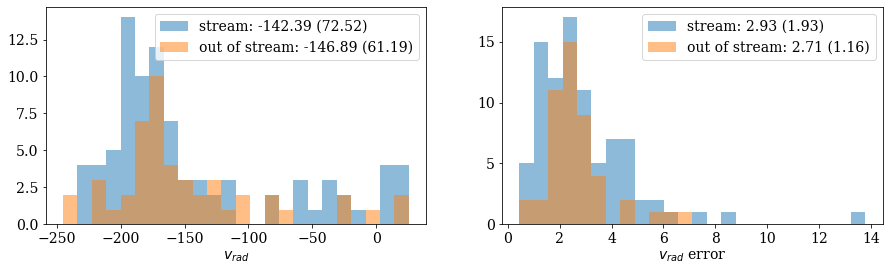

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
bins = np.linspace(min(gd1.VRAD), max(gd1.VRAD),25)
ax1.hist(in_stream.VRAD,bins=bins,alpha=0.5,label='stream: {:.2f} ({:.2f})'.format(np.mean(in_stream.VRAD), np.std(in_stream.VRAD)))
ax1.hist(out_stream.VRAD,bins=bins,alpha=0.5,label='out of stream: {:.2f} ({:.2f})'.format(np.mean(out_stream.VRAD), np.std(out_stream.VRAD)))
ax1.set_xlabel('$v_{rad}$')
ax1.legend()

bins = np.linspace(min(gd1.VRAD_ERR), max(gd1.VRAD_ERR),25)
ax2.hist(in_stream.VRAD_ERR,bins=bins,alpha=0.5,label='stream: {:.2f} ({:.2f})'.format(np.mean(in_stream.VRAD_ERR), np.std(in_stream.VRAD_ERR)))
ax2.hist(out_stream.VRAD_ERR,bins=bins,alpha=0.5,label='out of stream: {:.2f} ({:.2f})'.format(np.mean(out_stream.VRAD_ERR), np.std(out_stream.VRAD_ERR)))
ax2.set_xlabel('$v_{rad}$ error')
ax2.legend()

### Approx. linear model

In [7]:
x = np.array(gd1.PHI1)
y = np.array(gd1.VRAD)
yerr = np.array(gd1.VRAD_ERR)

In [8]:
RVX, RVY = (np.array([-47.49016522, -39.5436664, -31.43981117, -23.96538159, 
                      -17.27773407, -11.77025964, -5.71203777]),
            np.array([30.10772531, -21.56351641, -75.08015963, -119.36979539,
                    -161.81402966, -196.87665798, -246.70249821]))

RVI = scipy.interpolate.CubicSpline(RVX, RVY)

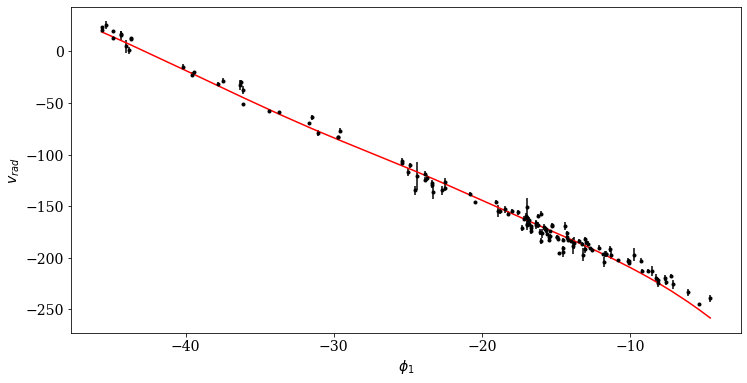

In [9]:
plt.figure(figsize=(12,6))
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, RVI(x), c='r')
plt.xlabel("$\phi_{1}$")
plt.ylabel("$v_{rad}$");

### Log-likelihood MCMC model

Taking model from Malhan & Ibata 2019 (sec. 4.1):

$$ln \mathcal{L} = \Sigma_{data} [- 1/2 (\frac{v_{los}^{m} - v_{los}^{d}}{\sigma_{v_{los, obs}}})^{2} -ln(\sigma_{v_{los, obs}}) ]$$

where, $$\sigma_{v_{los, obs}}^{2} = \sigma_{v_{los, int}}^{2} + f_{d}^{2} $$

and $f$ is $v_{rad}$ error from the pipeline

In [34]:
def log_like(p, vdiff, verr):
    sig, f = p
    sigma2 = (verr) ** 2 + sig**2
    ln = - 0.5 * vdiff ** 2 / sigma2 - 0.5*np.log(2*np.pi) - np.log(np.sqrt(sigma2)) + np.log(f)
    bg = np.full_like(vdiff, -np.log(max(gd1.VRAD)-min(gd1.VRAD))) + np.log(1-f)
    args = [ln, bg]
    ll = logsumexp(args, axis=0)
    return ll, args

In [11]:
def log_prior(p):
    sig, f = p
    if (sig < 0) or (sig > 200):
        return -np.inf
    if (f > 1) or (f < 0):
        return -np.inf
    return 0

In [35]:
def logprob(p, vdiff, verr):
    lp = log_prior(p)
    if not np.isfinite(lp):
        return -np.inf
    
    ll, args = log_like(p, vdiff, verr)

    return lp + ll.sum()

In [36]:
def model(p, vdiff, verr, title):

    vgrid = np.linspace(min(vdiff), max(vdiff), 100)
    errgrid = np.ones(len(vgrid)) * 2.9
    
    ll, args = log_like(p, vgrid, errgrid)
    pll = np.exp(ll)
    
    plt.hist(vdiff, density=True, color='grey')
    plt.plot(vgrid, pll, label=title)

In [37]:
x = np.array(gd1.PHI1)
y = np.array(gd1.VRAD)
verr = np.array(gd1.VRAD_ERR)
vdiff = y-RVI(x)

ndim = 2
nwalkers = 64
p0_guess = [5, 0.9]
p0 = p0_guess + 1e-4 * np.random.randn(64, 2)

In [38]:
res = minimize(lambda *args: -logprob(*args), x0=p0_guess, 
                   args=(vdiff,verr, ), method='L-BFGS-B')

/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


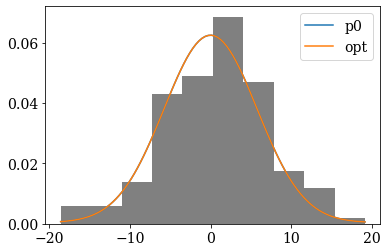

In [39]:
model(p0_guess, vdiff, verr,'p0')
model(res.x, vdiff, verr,'opt')
plt.legend()

In [40]:
nparams = len(p0_guess)
print(nparams)
nwalkers = 64
p0_guess = res.x
p0 = p0_guess + 1e-4 * np.random.randn(64, 2)
## Check to see things are initialized ok
lkhds = [logprob(p0[j], vdiff, verr) for j in range(nwalkers)]
assert np.all(np.array(lkhds) > -9e9)

2


Following emcee tutorial: https://emcee.readthedocs.io/en/stable/tutorials/line/

Run for all stars, in stream, and out of stream stars

In [41]:
labels = ['\sigma_{v_{rad}}','f']
def display_results(sampler, title):
    flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
    print('## {} ##'.format(title))
    for i in range(len(p0_guess)):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        display(Math(txt))
        
    fig = corner.corner(flat_samples, labels=labels, quantiles=[0.16,0.50,0.84], show_titles=True)
    #plt.hist(sig, bins=25, label=title, alpha=0.5)
    #plt.xlabel("$\sigma_{v_{rad}}$")

## GD1 ##


<IPython.core.display.Math object>

<IPython.core.display.Math object>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


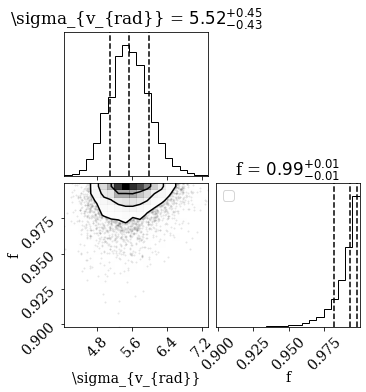

In [42]:
titles = ['GD1']

sampler = emcee.EnsembleSampler(nwalkers, len(p0_guess), logprob, args=(vdiff,verr))

state = sampler.run_mcmc(p0, 2048)
sampler.reset()
sampler.run_mcmc(state, 2048)

display_results(sampler, titles[0])
plt.legend()

In [45]:
def get_stream_prob(sampler, vdiff, verr):
    norm = 0.0
    post_prob = np.zeros(len(vdiff))
    for i in range(sampler.chain.shape[1]):
        for j in range(sampler.chain.shape[0]):
            p = sampler.chain[j][i]
            ll, (lgd1, lbg) = log_like(p, vdiff, verr)
            post_prob += np.exp(lgd1 - np.logaddexp(lgd1, lbg))
            norm += 1
    post_prob /= norm
    
    return post_prob

In [46]:
stream_prob = get_stream_prob(sampler, vdiff, verr)

In [47]:
gd1['stream_prob'] = stream_prob

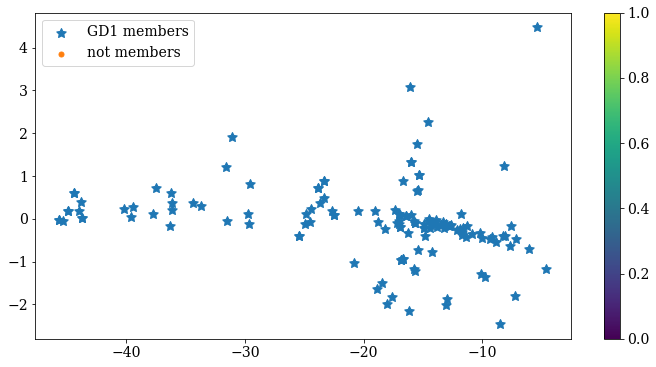

In [48]:
good_prob = gd1[gd1.stream_prob > 0.5]
bad_prob = gd1[gd1.stream_prob < 0.5]
plt.figure(figsize=(12,6))
plt.scatter(good_prob.PHI1, good_prob.PHI2, marker=(5,1), s=100, label='GD1 members')
plt.scatter(bad_prob.PHI1, bad_prob.PHI2, s=25, label='not members')
plt.colorbar()
plt.legend()

In [49]:
len(good_prob)

135

In [50]:
len(bad_prob)

0